In [195]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import time
import os
import numpy as np
import random
import itertools

from torchvision import datasets,transforms
from torchvision.utils import save_image


In [ ]:
from tqdm import tqdm
import time

pbar = tqdm(range(10)) ## tqdm 객체 생성
for i in pbar:
    time.sleep(0.01)
pbar.close() ## 반복이 끝나고 close 사용 강력 권장

print()
print('########### CROSS LINE ############')
print()

iterable = ['a', 'b', 'c', 'd', 'e']
pbar = tqdm(iterable, 
              total = len(iterable), ## 전체 진행수
              desc = 'Description', ## 진행률 앞쪽 출력 문장
              ncols = 100, ## 진행률 출력 폭 조절
              ascii = ' =', ## 바 모양, 첫 번째 문자는 공백이어야 작동
              leave = True, ## True 반복문 완료시 진행률 출력 남김. False 남기지 않음.
             )
for c in pbar:
    pbar.set_description(f'Current Character "{c}"') ## 또는 pbar.desc = f'Current Character "{c}"'
    time.sleep(0.2)
pbar.close()

In [196]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [197]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
    

# hyperparameters
training_epochs = 15
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [198]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)


In [199]:

class Encoder(nn.Module):
    def __init__(self,xdim=img_size**2,hdim=hiddendim,zdim=latentdim):
        super(Encoder,self).__init__()
        
    
        self.encode1 = nn.Sequential(
            nn.Linear(xdim,hdim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        self.encode2 = nn.Sequential(
            nn.Linear(hdim,hdim),
            nn.GELU(),
            nn.Dropout(0.3)
        )

        self.mu = nn.Linear(hdim,zdim)
        self.logvar = nn.Linear(hdim,zdim)
    def forward(self,x):
        x = self.encode1(x)
        x = self.encode2(x)
        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))
        
        ## reparameterize
        """
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        z =  mu + eps * std
        """
        
        eps = torch.randn_like(logvar)
        z = mu + logvar*eps/mu
        
        return z,mu,logvar
    

class Decoder(nn.Module):
    def __init__(self,xdim=img_size**2,hdim=hiddendim,zdim=latentdim):
        super(Decoder,self).__init__()
        
        self.decoder1 = nn.Sequential(
            nn.Linear(zdim,hdim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        self.decoder2 = nn.Sequential(
            nn.Linear(hdim,hdim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        self.decoder3 = nn.Sequential(
            nn.Linear(hdim,xdim),
        )
        
    def forward(self,z):
        z = self.decoder1(z)
        z = self.decoder2(z)
        z = self.decoder3(z)
        y = F.sigmoid(z)
        # return y.view(-1,28,28)
        return y.view(-1,28,28)
    
img_size = 28
hiddendim = 256
latentdim = 32
        

enco = Encoder(xdim=784,hdim=77,zdim=20)
deco = Decoder(xdim=784,hdim=77,zdim=20)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [200]:
dummy = torch.randn(13,784)
z,mu,logvar = enco(dummy)
y = deco(z)
y.shape


torch.Size([13, 28, 28])

In [201]:
n_epochs = 10

In [202]:
optimizer = torch.optim.Adam(
    itertools.chain(enco.parameters(), deco.parameters()), lr=lr, betas=(b1, b2)
)
from tqdm import tqdm
import time


for epoch in range(n_epochs):
    total_loss = 0
    for i, (img, _) in enumerate(tqdm(data_loader)):
        # forward
        img = img.view(-1,img_size,img_size)
        x = img.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = enco(x)
        x_reconst = deco(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, img, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        total_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch : {epoch}')
    print(f'total_loss : {total_loss//batch_size}')


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


RuntimeError: all elements of input should be between 0 and 1

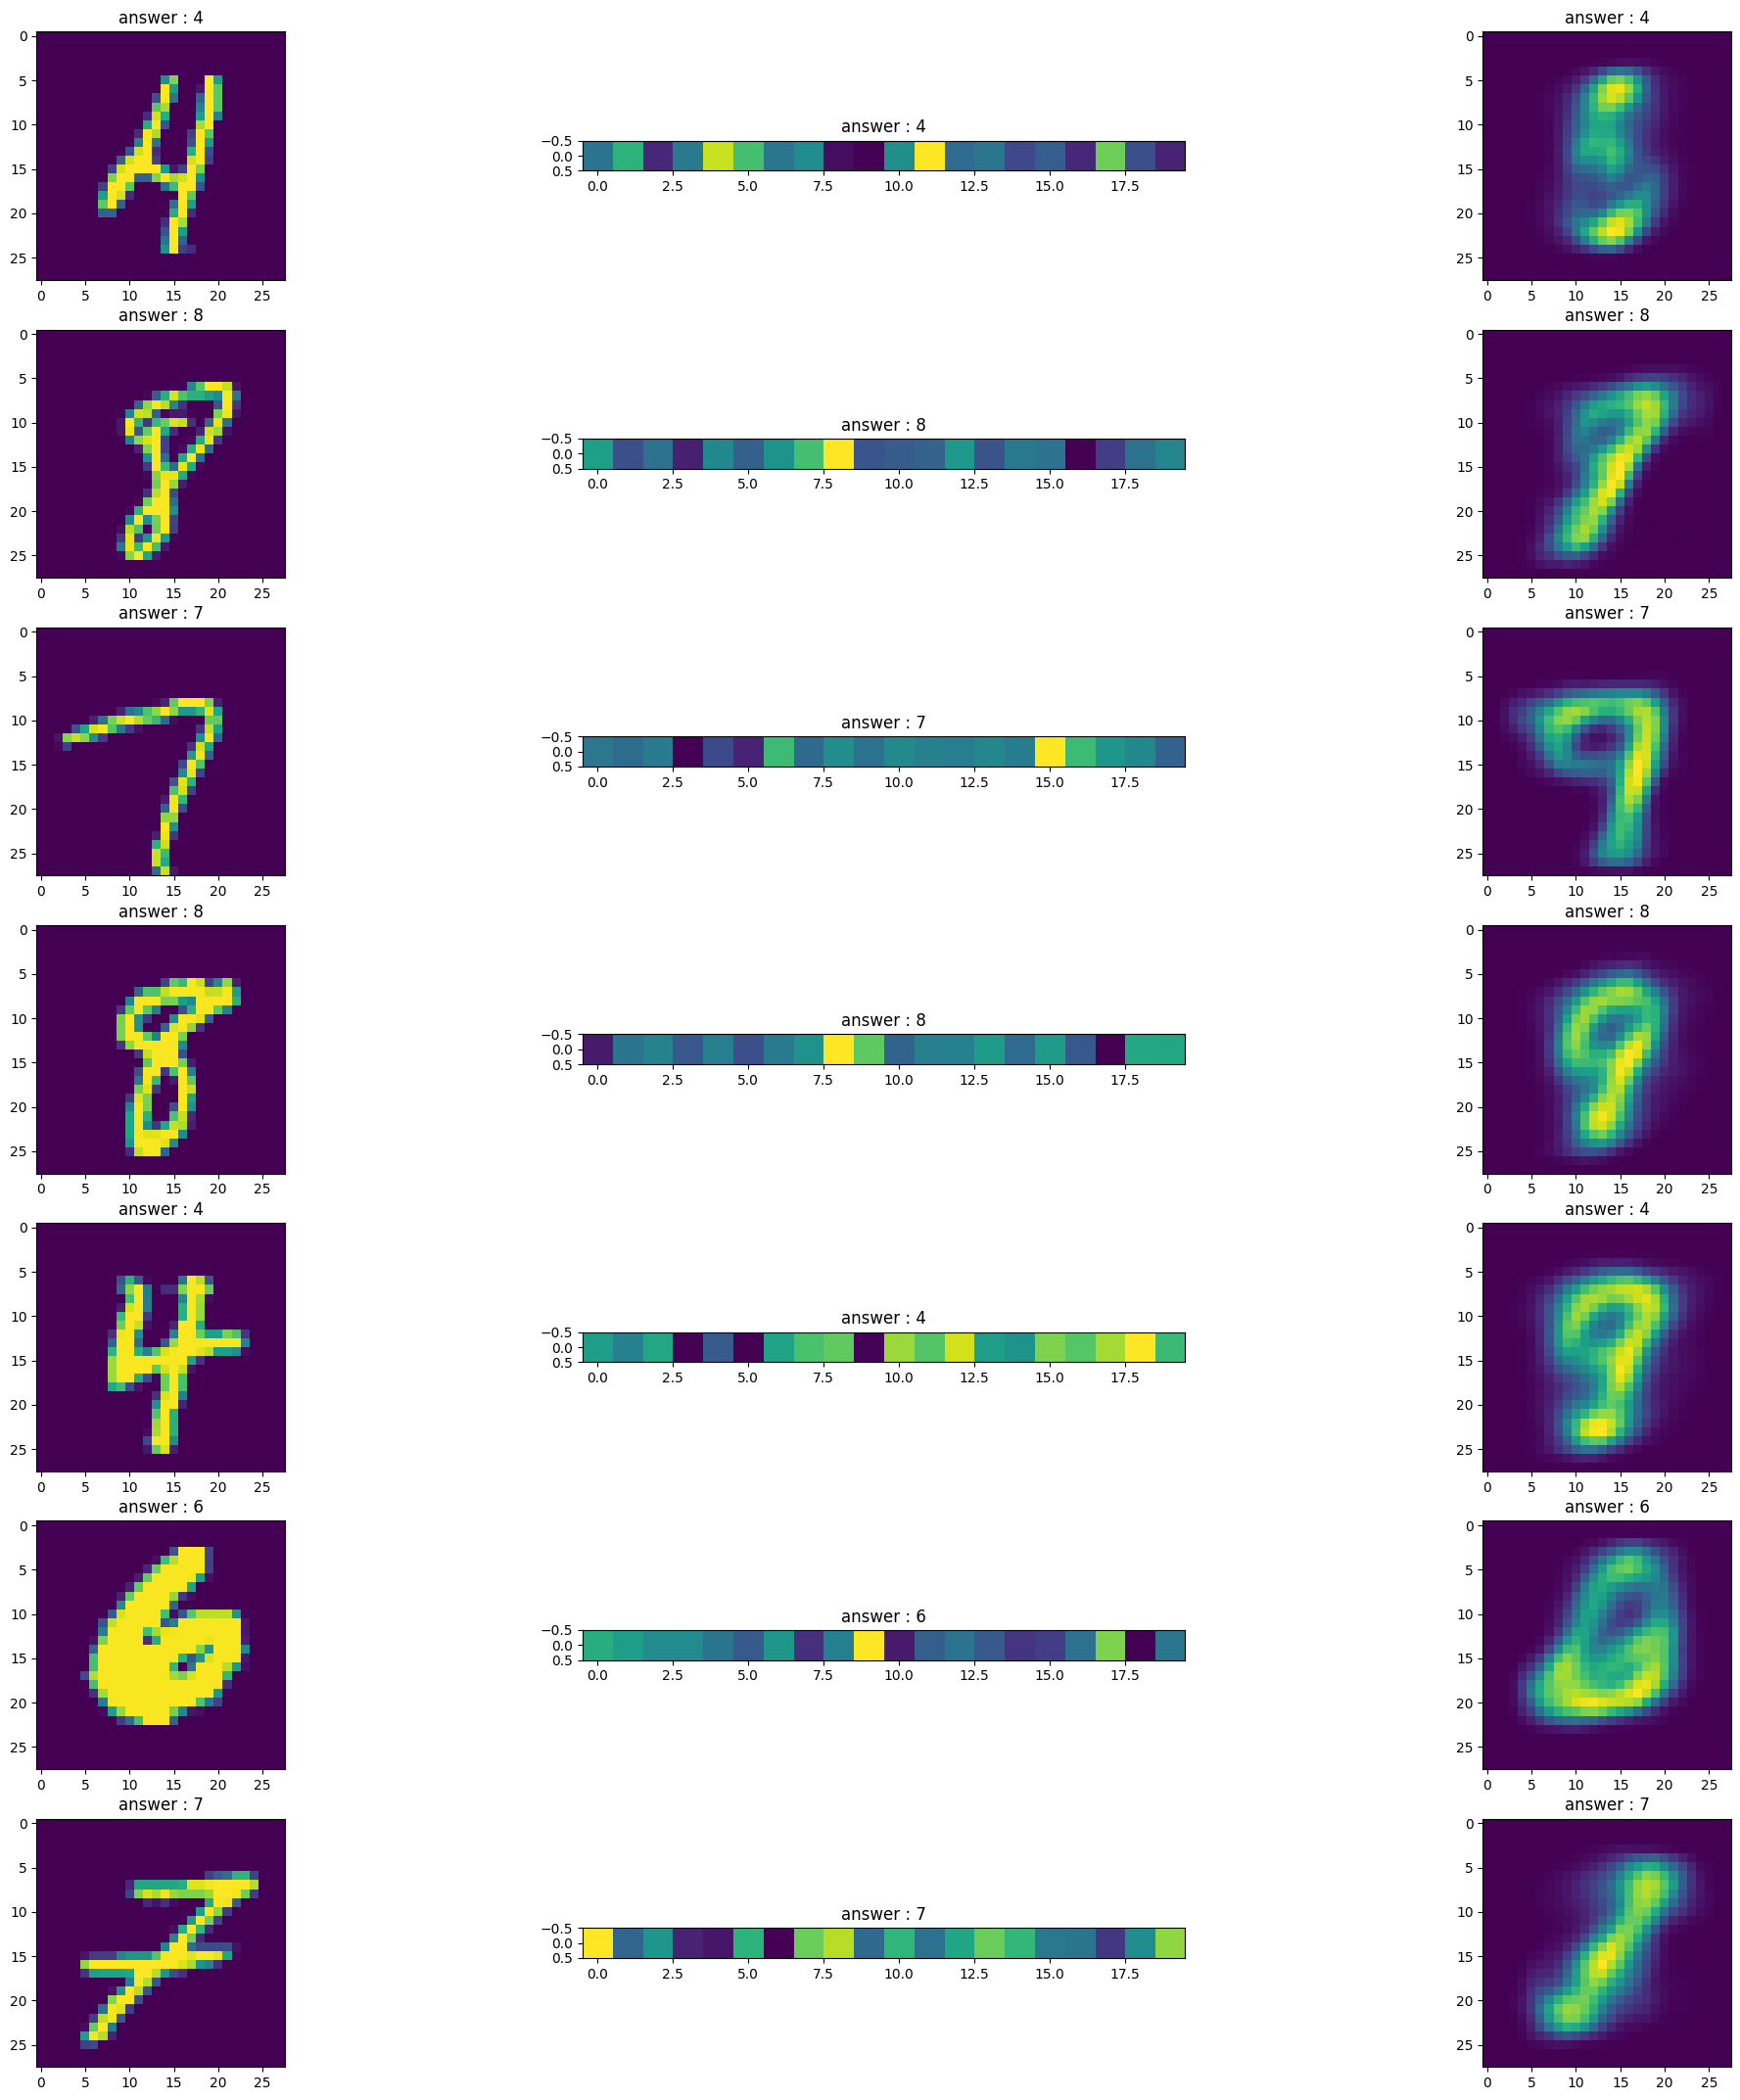

In [ ]:
import matplotlib.pyplot as plt


for img,answer in data_loader:
    img = img.view(-1,img_size,img_size)
    x = img.view(-1, img_size**2)
    x = x.to(device)
    z, mu, logvar = enco(x)
    break
output = deco(z)

# output.detach().numpy()[:5]는 5개의 이미지를 포함하는 NumPy 배열입니다.
# 이를 2행 3열로 배치하기 위해 subplots() 함수를 사용합니다.
fig, axarr = plt.subplots(7, 3, figsize=(27, 27))

# 각 이미지를 서브플롯에 표시합니다.
for i, x_hat in enumerate(output.detach().numpy()[:7]):
    axarr[i , 0].imshow(img.numpy()[i])
    axarr[i , 0].set_title(f'answer : {answer[i]}')
    axarr[i , 1].imshow(z.view(-1,1,20).detach().numpy()[i])
    axarr[i , 1].set_title(f'answer : {answer[i]}')
    axarr[i , 2].imshow(x_hat)
    axarr[i , 2].set_title(f'answer : {answer[i]}')
    

plt.show()


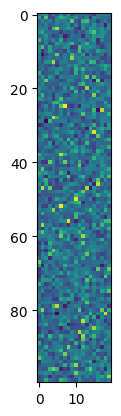

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(z.detach().numpy())